In [ ]:
import time
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import json
from torch.utils import data
import numpy as np
import random
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
import matplotlib
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
# import matplotlib.ticker as ticker

In [ ]:
device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
SOS_token = 0
EOS_token = 1
#----------Hyper Parameters----------#
hidden_size = 256
#The number of vocabulary
vocab_size = 29
teacher_forcing_ratio = 0.5
LR = 0.0002
MAX_LENGTH=512

In [ ]:
#Encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size=torch.LongTensor(input_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size)
        self.gru = nn.LSTM(input_size=hidden_size,hidden_size=hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        # print(input[0].shape)
        # embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, self.input_size)
        output = embedded
        output, (hidden,cell) = self.gru(output)
        # output, hidden = self.gru(output,hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
#Decoder
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        # self.gru = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output[0])
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        # self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.gru = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, (hidden,cell) = self.gru(output)
        # output,hidden=self.gru(output,hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def get_pair(file):
  with open('/content/drive/My Drive/Colab_Notebooks/lab4/'+file,'r') as f:
    data=json.load(f)
  pair=[]
  for i in range(len(data)):
    for j in range(len(data[i]["input"])):
      arr=[data[i]["input"][j],data[i]["target"]]
      pair.append(arr)
  return np.array(pair)

In [ ]:
class Vocabulary(object):
    def __init__(self):
        self.char2idx = {'SOS': 0, 'EOS': 1,}
        self.idx2char = {0: 'SOS', 1: 'EOS'}
        for c in range(ord('a'), ord('z') + 1):
          self.char2idx[chr(c)]=c-95
          self.idx2char[c-95]=chr(c)
        self.num_chars = 28

    def sequence_to_indices(self, sequence, add_eos=False, add_sos=False):
        """Transform a char sequence to index sequence
            :param sequence: a string composed with chars
            :param add_eos: if true, add the <EOS> tag at the end of given sentence
            :param add_sos: if true, add the <SOS> tag at the beginning of given sentence
        """
        index_sequence = [self.char2idx['SOS']] if add_sos else []

        for char in self.split_sequence(sequence):
            if char not in self.char2idx:
                index_sequence.append((self.char2idx['UNK']))
            else:
                index_sequence.append(self.char2idx[char])

        if add_eos:
            index_sequence.append(self.char2idx['EOS'])

        return index_sequence

    def indices_to_sequence(self, indices):
        """Transform a list of indices
            :param indices: a list
        """
        sequence = ""
        for idx in indices:
            char = self.idx2char[idx]
            if char == "EOS":
                break
            else:
                sequence += char
        return sequence

    def split_sequence(self, sequence):
        """Vary from languages and tasks. In our task, we simply return chars in given sentence
        For example:
            Input : alphabet
            Return: [a, l, p, h, a, b, e, t]
        """
        return [char for char in sequence]

vocab=Vocabulary()

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, word):
  # indexes = indexesFromSentence(lang, sentence)
  indexes=[]
  indexes.append(lang.word2index[word])
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# def tensorsFromPair(pair):
#   input_tensor = tensorFromSentence(input_lang, pair[0])
#   target_tensor = tensorFromSentence(output_lang, pair[1])
#   return (input_tensor, target_tensor)

def tensorsFromPair(pair):
  input_tensor = vocab.sequence_to_indices(pair[0],True)
  input_tensor = torch.tensor(input_tensor, dtype=torch.long, device=device).view(-1, 1)
  target_tensor = vocab.sequence_to_indices(pair[1],True)
  target_tensor = torch.tensor(target_tensor, dtype=torch.long, device=device).view(-1, 1)
  return (input_tensor, target_tensor)

pairs=get_pair('train.json')
# input,out=tensorsFromPair(pairs[0])
# input.shape

In [ ]:
class VocabLoader(data.Dataset):
    def __init__(self):
        with open('train.json','r') as f:
          self.data=json.load(f)

    def __len__(self):
        """'return the size of dataset"""
        return len(self.data)

    def __getitem__(self, index):
      input=self.data[index]["input"]
      for i in range(len(input)):
        input[i]=list(input[i])
        for j in range(len(input[i])):
          input[i][j]=ord(input[i][j])-94
        input[i].append(EOS_token)
      input=torch.cuda.LongTensor(input,device=device)

      target=self.data[index]["target"]
      target=list(target)
      for i in range(len(target)):
        target[i]=ord(target[i])-95
      target=torch.cuda.LongTensor(target,device=device)
      return input,target

In [ ]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

   
    #----------sequence to sequence part for encoder----------#
    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] = encoder_output[0, 0]
    # encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)


    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
	

    #----------sequence to sequence part for decoder----------#
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # decoder_output, decoder_hidden = decoder(
            #     decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # decoder_output, decoder_hidden = decoder(
                # decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    # try gradient clipping
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def showPlot(points,iter):
    # plt.figure()
    # print(points,iter)
    # fig, ax = plt.subplots()
    # # this locator puts ticks at regular intervals
    # loc = ticker.MultipleLocator(base=0.2)
    # ax.yaxis.set_major_locator(loc)
    plt.plot(iter,points)
    plt.show()

0m 0s (- 3m 53s) (10 0%) 3.3737
0m 0s (- 4m 29s) (20 0%) 3.3585
0m 1s (- 4m 25s) (30 0%) 3.3542
0m 1s (- 4m 25s) (40 0%) 3.1752
0m 1s (- 4m 24s) (50 0%) 3.2672
0m 2s (- 4m 20s) (60 0%) 2.4204
0m 2s (- 4m 18s) (70 1%) 3.2758
0m 2s (- 4m 9s) (80 1%) 3.1791
0m 3s (- 4m 5s) (90 1%) 2.8714
0m 3s (- 4m 0s) (100 1%) 3.2310
0m 3s (- 3m 56s) (110 1%) 2.6042
0m 4s (- 3m 55s) (120 1%) 2.5485
0m 4s (- 3m 57s) (130 1%) 3.2743
0m 4s (- 3m 55s) (140 2%) 3.2502
0m 5s (- 3m 56s) (150 2%) 3.2348
0m 5s (- 3m 56s) (160 2%) 3.2365
0m 5s (- 3m 56s) (170 2%) 3.2411
0m 6s (- 3m 59s) (180 2%) 3.0515
0m 6s (- 3m 58s) (190 2%) 2.9395
0m 6s (- 3m 57s) (200 2%) 2.5485
0m 7s (- 3m 56s) (210 3%) 3.1884
0m 7s (- 3m 56s) (220 3%) 3.1754
0m 7s (- 3m 55s) (230 3%) 3.1447
0m 8s (- 3m 55s) (240 3%) 3.1532
0m 8s (- 3m 56s) (250 3%) 2.8752
0m 9s (- 3m 55s) (260 3%) 2.8381
0m 9s (- 3m 53s) (270 3%) 2.1275
0m 9s (- 3m 53s) (280 4%) 2.7863
0m 10s (- 3m 52s) (290 4%) 2.4131
0m 10s (- 3m 52s) (300 4%) 2.7204
0m 10s (- 3m 51s) (3

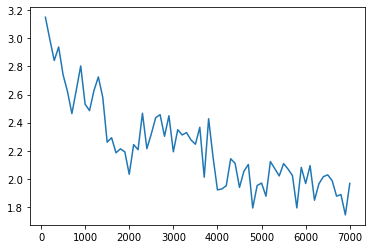

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    plot_iter=[]
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # your own dataloader
    # with open('train.json', 'r') as f:
    #   training_pairs = VocabLoader()

    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        # training_pair = training_pairs[iter - 1]
        # input_tensor = training_pair[0]
        # target_tensor = training_pair[1]
        input_tensor,target_tensor=tensorsFromPair(random.choice(pairs))
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            plot_iter.append(iter)

    showPlot(plot_losses,plot_iter)

# encoder1 = EncoderRNN(vocab_size, hidden_size).to(device)
encoder1 = EncoderRNN(vocab_size, hidden_size).to(device)
decoder1 = AttnDecoderRNN(hidden_size, vocab_size).to(device)
trainIters(encoder1, decoder1,7000, print_every=10)

In [ ]:
#compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

def evaluate(encoder, decoder, input_tensor, max_length=MAX_LENGTH):
    with torch.no_grad():
        # input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(vocab.idx2char[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
pairs=get_pair('test.json')
outputs=[]
reference=[]
for i in range(10):
        pair = random.choice(pairs)
        input_tensor,target_tensor=tensorsFromPair(pair)
        print('input :', pair[0])
        print('target :', pair[1])
        output_words,attention= evaluate(encoder1, decoder1, input_tensor)
        print('pred :',"".join(output_words[:-1]))
        outputs.append("".join(output_words[:-1]))
        reference.append(pair[1])
        print('==============================================')
print('BLEU-4 score :',compute_bleu(outputs,reference))


input : enxt
target : next
pred : pore
input : scadual
target : schedule
pred : pore
input : powerfull
target : powerful
pred : pore
input : dirven
target : driven
pred : pore
input : recetion
target : recession
pred : pore
input : leval
target : level
pred : pe
input : firery
target : fiery
pred : pore
input : decant
target : decent
pred : pore
input : leason
target : lesson
pred : pore
input : havest
target : harvest
pred : pont
BLEU-4 score : 0
